# PyTorch Projects Part 2

In Part 2 we largely limited us to the Personal projects more. While there were more assignments completed we added mostly personal projects in this notebook. This notebook contains following projects:

1. Dog Breed Classifier using Vision Transformers
2. Car Data Regression using Lightening and callbacks
3. Variational AutoEncoder (VAE) for Image Compression
4. Fake Celebrity Face Generator: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset 

## Dog Breed Classifier

In part 1 of projects we covered Dog Breed Classifier using our custom CNN model and got 91.67% accuracy. This time we will finetune a VIT model using timm libarary on same dataset and observe the differences.

In [2]:
import timm as timm

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean = IMAGENET_DEFAULT_MEAN, std = IMAGENET_DEFAULT_STD)]
)

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = IMAGENET_DEFAULT_MEAN, std = IMAGENET_DEFAULT_STD)]
)

In [5]:
train_data = datasets.ImageFolder('train/', transform= transform_train)
test_data = datasets.ImageFolder('test/', transform= transform_test)

train_loader = DataLoader(train_data, batch_size= 16, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 16, shuffle= False)
class_names = train_data.classes
print('Class Names:', class_names)

Class Names: ['affenpinscher', 'akita', 'corgi']


In [6]:
from torchinfo import summary

In [7]:
device = torch.device('cuda')
model = timm.create_model(model_name= 'vit_base_patch16_224', num_classes = 3, pretrained = True).to(device)

for p in model.parameters():
    p.requires_grad = False

for p in model.get_classifier().parameters():
    p.requires_grad = True

summary(model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        152,064
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (590,592)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─Attention: 3-2               (2,362,368)
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               (1,536)
│    │    └─Mlp: 3-6                     (4,722,432)
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               (1,536)
│    │    └─Attention: 3-10              (2,362,368)
│    │    └─Ident

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params= model.parameters(), lr = 0.001, weight_decay= 0.05)

model.train()
for epoch in range(20):
    train_loss = 0.0
    correct = 0.0
    total_samples = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()*xb.size(0)
        total_samples = total_samples + xb.size(0)
        preds = logits.argmax(dim = 1)
        correct = correct + (preds == yb).sum().item()

    print(f'Epoch {epoch + 1} | loss: {train_loss/total_samples} | accuracy: {correct/total_samples}')

Epoch 1 | loss: 0.364426686809061 | accuracy: 0.8538205980066446
Epoch 2 | loss: 0.014247410892790486 | accuracy: 0.9966777408637874
Epoch 3 | loss: 0.010965904293649914 | accuracy: 0.9966777408637874
Epoch 4 | loss: 0.006122422731787808 | accuracy: 1.0
Epoch 5 | loss: 0.004616265539064434 | accuracy: 1.0
Epoch 6 | loss: 0.008323836759153592 | accuracy: 1.0
Epoch 7 | loss: 0.004215491982022195 | accuracy: 1.0
Epoch 8 | loss: 0.0028317778022608647 | accuracy: 1.0
Epoch 9 | loss: 0.002329104734689888 | accuracy: 1.0
Epoch 10 | loss: 0.001831821641212552 | accuracy: 1.0
Epoch 11 | loss: 0.0019617775985754505 | accuracy: 1.0
Epoch 12 | loss: 0.0017042609347042896 | accuracy: 1.0
Epoch 13 | loss: 0.0017603909971186291 | accuracy: 1.0
Epoch 14 | loss: 0.0011685638335777874 | accuracy: 1.0
Epoch 15 | loss: 0.02090350274565905 | accuracy: 0.9966777408637874
Epoch 16 | loss: 0.0014817891480011303 | accuracy: 1.0
Epoch 17 | loss: 0.0050140815840003725 | accuracy: 1.0
Epoch 18 | loss: 0.003024712

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        preds = logits.argmax(dim = 1)
        correct = correct + (preds == yb).sum().item()
        total += xb.size(0)
    print(f'Test Accuracy: {correct/total}')

Test Accuracy: 1.0


In [10]:
images, label = next(iter(test_loader))

In [11]:
import matplotlib.pyplot as plt
import numpy as np

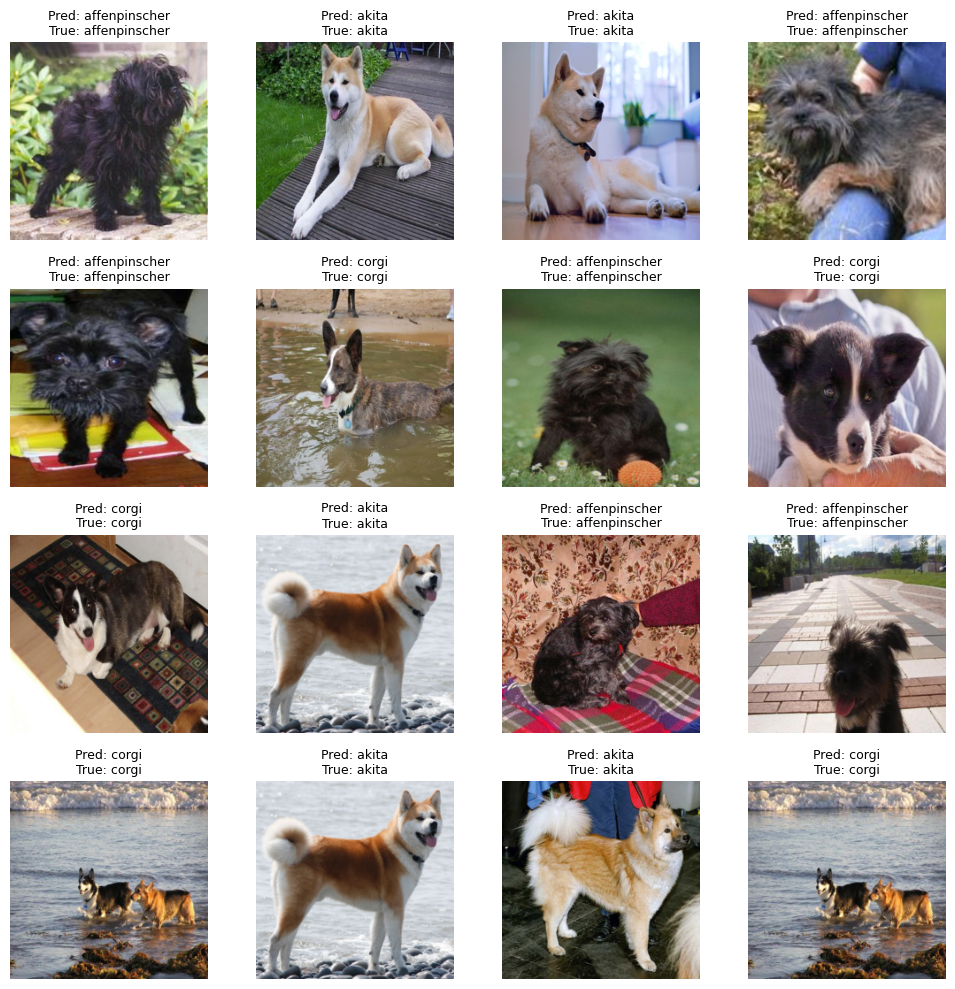

In [12]:
model.eval()
test_loader_plt = DataLoader(test_data, batch_size= 16, shuffle= True)
images, labels = next(iter(test_loader_plt))
with torch.no_grad():
    logits = model(images.to(device))
    preds = logits.argmax(1).cpu()


mean = torch.tensor(IMAGENET_DEFAULT_MEAN).view(1,3,1,1)
std  = torch.tensor(IMAGENET_DEFAULT_STD).view(1,3,1,1)
images_vis = images.cpu() * std + mean

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    img = images_vis[i].permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


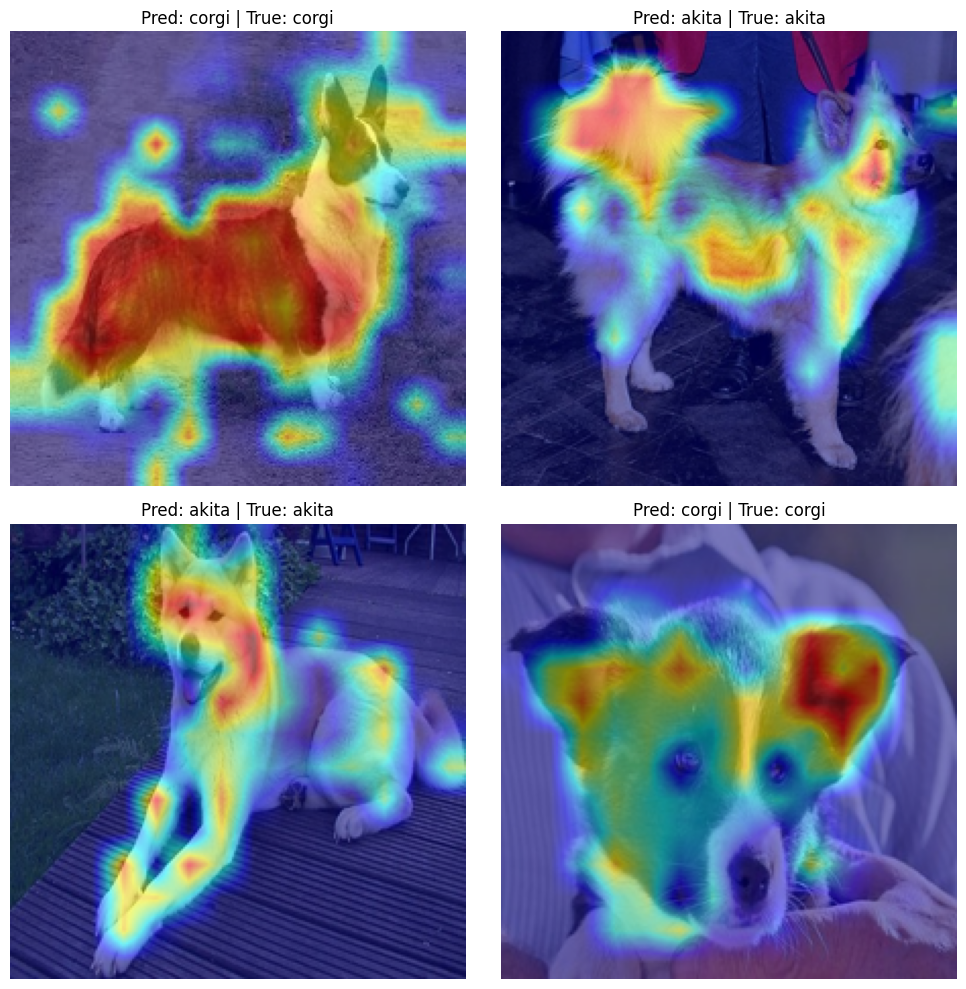

In [44]:
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform
import random 

target_layers = [model.blocks[-1].norm1]

cam = GradCAM(
    model=base_model,
    target_layers=target_layers,
    reshape_transform=vit_reshape_transform,
)

def show_4_gradcams(model, test_data, class_names, device):
    idxs = random.sample(range(len(test_data.samples)), 4)
    paths_and_labels = [test_data.samples[i] for i in idxs]

    plt.figure(figsize=(10, 10))
    model.eval()
    for i, (img_path, true_idx) in enumerate(paths_and_labels, start=1):
        pil_img = Image.open(img_path).convert('RGB')
        pil_resized = pil_img.resize((224, 224))
        rgb_img = np.array(pil_resized).astype(np.float32) / 255.0

        x = transform_test(pil_img).unsqueeze(0).to(device).requires_grad_(True)

        with torch.no_grad():
            logits = model(x)
            pred_idx = int(torch.argmax(logits, dim=1).item())

        targets = [ClassifierOutputTarget(pred_idx)]
        with torch.enable_grad():
            grayscale_cam = cam(input_tensor=x, targets=targets)
        cam_map = grayscale_cam[0]
        cam_image = show_cam_on_image(rgb_img, cam_map, use_rgb=True)

        plt.subplot(2, 2, i)
        plt.imshow(cam_image)
        plt.axis('off')
        plt.title(f'Pred: {class_names[pred_idx]} | True: {class_names[true_idx]}')

    plt.tight_layout()
    plt.show()


show_4_gradcams(model, test_data, class_names, device)

We obtained 100% test accuracy compared to 91.67% accuracy in our previous model. And by looking at the gradcam images we were able to observe clearly that model is focusing on key features of dog breeds, difference in ears, tails, mouth, spots, and many other differentiating features. In contrast our previous custom CNN solution was focusing only on ears largely, which while is indeed a differentating feature, it is not only one of them.

# Car Data Regression

This is an assignment for car dataset regression. Focus is on making lightening module with callbacks.

In [1]:
#%% packages
import graphlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns


import pytorch_lightning as pl

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

#%% data import
cars_file = 'https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv'
cars = pd.read_csv(cars_file)
cars.head()

#%% convert data to tensor
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1,1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1,1)
X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

#%% Dataset and Dataloader
class LinearRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(dataset = LinearRegressionDataset(X_np, y_np), batch_size=2)



#%%

class LitLinearRegression(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super(LitLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.loss_fun = nn.MSELoss()
    
    def forward(self, x):
        return self.linear(x)

    def configure_optimizers(self):
        learning_rate = 0.02
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch

        # forward pass
        y_pred = self.forward(X)

        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def val_step(self, val_batch, batch_idx):
        X, y = val_batch

        # forward pass
        y_pred = model(X)

        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

#%% model instance and training
# model instance
model = LitLinearRegression(input_size=1, output_size=1)

# training
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.0001, patience=2, verbose=True, mode="min")

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=500, log_every_n_steps=2, callbacks=[early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader)

# %% after how many steps the model converged?
trainer.current_epoch

# %% get model parameters
for parameter in model.parameters():
    print(parameter)
# %%


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are usi

Training: |                                                                                       | 0/? [00:00…

Metric train_loss improved. New best score: 34.151
Metric train_loss improved by 2.254 >= min_delta = 0.0001. New best score: 31.897
Metric train_loss improved by 2.083 >= min_delta = 0.0001. New best score: 29.814
Metric train_loss improved by 1.930 >= min_delta = 0.0001. New best score: 27.884
Metric train_loss improved by 1.788 >= min_delta = 0.0001. New best score: 26.096
Metric train_loss improved by 1.658 >= min_delta = 0.0001. New best score: 24.438
Metric train_loss improved by 1.537 >= min_delta = 0.0001. New best score: 22.901
Metric train_loss improved by 1.426 >= min_delta = 0.0001. New best score: 21.476
Metric train_loss improved by 1.323 >= min_delta = 0.0001. New best score: 20.153
Metric train_loss improved by 1.228 >= min_delta = 0.0001. New best score: 18.925
Metric train_loss improved by 1.140 >= min_delta = 0.0001. New best score: 17.785
Metric train_loss improved by 1.059 >= min_delta = 0.0001. New best score: 16.726
Metric train_loss improved by 0.984 >= min_delt

Parameter containing:
tensor([[-5.7216]], requires_grad=True)
Parameter containing:
tensor([36.6905], requires_grad=True)


# VAE

In this project we will create a custom VAE model on the provided dataset. While model was properly designed and trained we were limited with pixelated dataset leading to VAE not working so well compared to normal AutoEncoder. But we will use this model with some tweaks for our main project in this notebook: Fake Celebrity Face generator.

In [66]:
# VAE

import torch
import torch.nn as nn
from torchinfo import summary

class ResBlock(nn.Module):
    def __init__(self, in_channels = 32, output_channels = 64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = output_channels
        self.expansion = nn.Conv2d(in_channels= in_channels, out_channels=output_channels, kernel_size= 1)

        self.main_block = nn.Sequential(
            nn.Conv2d(in_channels= in_channels, out_channels= output_channels, kernel_size = 3, dilation= 1, padding = 1),
            nn.Conv2d(in_channels= output_channels, out_channels= output_channels, kernel_size = 3, dilation= 1, padding = 1)
        )

        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(stride= 2, kernel_size=3)

    def forward(self, inputs):
        if self.in_channels != self.out_channels:
            identity = self.expansion(inputs)
        else:
            identity = inputs
        x = self.main_block(inputs)
        x = self.batchnorm(x)
        x = self.relu(x + identity)
        return self.pool(x)


class Encoder(nn.Module):
    def __init__(self, in_channels = 3, latent_dims = 16):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels= in_channels, out_channels= 64, kernel_size = 3, padding = 1),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.resblock1 = ResBlock(in_channels=64, output_channels=128)
        self.resblock2 = ResBlock(in_channels=128, output_channels=128)
        self.resblock3 = ResBlock(in_channels=128, output_channels=256)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(), 
            nn.Linear(in_features= 256, out_features= 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features= 1024, out_features= 512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.mean = nn.Sequential(
            nn.Linear(512, out_features= latent_dims)
        )

        self.logvar = nn.Sequential(
            nn.Linear(512, out_features= latent_dims)
        )

    def forward(self, inputs):
        x = self.stem(inputs) 
        x = self.resblock1(x) 
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.head(x)
        mean = self.mean(x)
        logvar = self.logvar(x)

        return mean, logvar

In [140]:
from torchvision import models

class ResNet18Encoder(nn.Module):
    def __init__(self, latent_dims=64):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Keep the backbone blocks as attributes for easy freezing/unfreezing
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        feat_dim = 512
        self.mu = nn.Linear(feat_dim, latent_dims)
        self.logvar = nn.Linear(feat_dim, latent_dims)

        # 1) Freeze everything
        for p in self.backbone.parameters():
            p.requires_grad = False

        # 2) Unfreeze only layer4[1] (second block in layer4)
        for p in self.backbone[-1][1].parameters():  # layer4[1]
            p.requires_grad = True

        # 3) Keep heads trainable
        for p in self.mu.parameters():
            p.requires_grad = True
        for p in self.logvar.parameters():
            p.requires_grad = True

        # 4) Freeze BN running stats in the frozen part
        self._set_frozen_bn_eval()

    def _set_frozen_bn_eval(self):
        # Put BatchNorm in eval mode for frozen modules, so running stats won’t update
        for m in self.backbone[:-1].modules():  # all except layer4 (we’re fine‑tuning inside layer4)
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                # also make affine params not trainable if they’re in frozen part
                if m.affine:
                    m.weight.requires_grad_(False)
                    m.bias.requires_grad_(False)

    def forward(self, x_in):
        x = (x_in + 1.0) * 0.5
        # [0,1] -> ImageNet normalization
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = x.new_tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        x = (x - mean) / std

        h = self.backbone(x)          # [B, 512, 4, 4] for 128×128 inputs
        h = self.pool(h).flatten(1)   # [B, 512]
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar


In [67]:
device = torch.device('cuda')

model = Encoder().to(device)
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 16]                   --
├─Sequential: 1-1                        [1, 64, 111, 111]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─Conv2d: 2-2                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 111, 111]         --
├─ResBlock: 1-2                          [1, 128, 55, 55]          --
│    └─Conv2d: 2-6                       [1, 128, 111, 111]        8,320
│    └─Sequential: 2-7                   [1, 128, 111, 111]        --
│    │    └─Conv2d: 3-1                  [1, 128, 111, 111]        73,856
│    │    └─Conv2d: 3-2                  [1, 128, 111, 111]        147,584
│    └─BatchNorm2d: 2-8                  [1, 128, 111, 111]      

In [68]:
x = torch.randn(8, 3, 64, 64).to(device)
mu, logvar = model(x)  # instantiate first, then call
print(mu.shape, logvar.shape)  # torch.Size([8, 16]) each


torch.Size([8, 16]) torch.Size([8, 16])


In [69]:
def reparamaterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    error = torch.randn_like(mu)

    return mu + error*std

In [192]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims = 16):
        super().__init__()
        self.expansion = nn.Linear(in_features= latent_dims, out_features= 256*16*16)

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(kernel_size= 4, in_channels= 256, out_channels= 128, padding= 1, stride = 2, bias = False),
            nn.ReLU(inplace= True)
        )

        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(kernel_size= 4, in_channels= 128, out_channels= 128, padding= 1, stride = 2, bias = False),
            nn.ReLU(inplace= True)
        )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(kernel_size= 4, in_channels= 128, out_channels= 64, padding= 1, stride = 2, bias = False),
            nn.ReLU(inplace= True)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(kernel_size= 3, in_channels= 64, out_channels= 3, padding= 1, bias = False),
            nn.Tanh()
        )

    def forward(self, inputs):
        
        batch_size = inputs.size(0)
        x = self.expansion(inputs).view(batch_size, 256, 16, 16)
        x = self.block1(x)
        x = self.block2(x)

        x = self.block3(x)

        x = self.block4(x)

        return x

In [116]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import lightning as L
import torch.nn.functional as F

In [117]:
class VaeDataLoader(L.LightningDataModule):
    def __init__(self, data_dir = None, img_size = 128, batch_size = 16):
        super().__init__()
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.Lambda(lambda im: im.convert("RGB")),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean= (0.5,0.5,0.5), std = (0.5,0.5,0.5))
        ])

        self.train = None

    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train = datasets.ImageFolder(root=self.data_dir, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(dataset= self.train, batch_size= self.batch_size, shuffle = True, pin_memory= True, persistent_workers= True, num_workers=12)
    

vae_data = VaeDataLoader(data_dir= 'data/train', img_size = 128, batch_size=16)

def kl_divergence(mu, logvar):
    kl = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    return kl.sum(dim = 1).mean()

In [118]:
vae_data.setup('fit')

In [119]:
print(vae_data.train.class_to_idx)  # class name -> index mapping
img, label = vae_data.train[0]      # a single sample
print(img.shape)

{'apples': 0, 'bananas': 1}
torch.Size([3, 128, 128])


In [120]:
dm = VaeDataLoader(data_dir = "data/train", img_size=128, batch_size=16)
dm.setup("fit")
imgs, labels = next(iter(dm.train_dataloader()))
print(imgs.shape)  # torch.Size([16, 3, 128, 128])

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([16, 3, 128, 128])


In [76]:
0.2 + 1*(20/70)

0.4857142857142857

In [77]:
20/25

0.8

In [126]:
class VAEModel(L.LightningModule):
    def __init__(self, encoder = None, decoder = None, lr = 0.0001):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.lr = lr

        self.save_hyperparameters(ignore= ['encoder', 'decoder'])

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr= self.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=3
            )
        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train/loss",
                "interval": "epoch"            },
        }

    def forward(self, inputs):
        mu, logvar = self.encoder(inputs)
        z = reparamaterize(mu = mu, logvar = logvar)
        x = self.decoder(z)

        return x, mu, logvar

    def _compute_loss(self, inputs):
        x, mu, logvar = self(inputs)
        B = inputs.size(0)
        recon = F.l1_loss(x, inputs, reduction='mean')

        warmup_epochs = 20
        beta = min(0.9, (self.current_epoch + 1) / warmup_epochs)

        kl = beta * kl_divergence(mu, logvar)

        loss = recon + kl
        return loss, recon, kl

    def training_step(self, batch, idx):
        img, _ = batch
        loss, recon, kl = self._compute_loss(img)
        current_lr = self.optimizers().param_groups[0]["lr"]

        self.log('train/loss', loss, prog_bar= True, on_epoch= True, batch_size= img.size(0))
        self.log("train/recon", recon, prog_bar=False, on_epoch=True, batch_size=img.size(0))
        self.log("train/kl", kl, prog_bar=False, on_epoch=True, batch_size=img.size(0))
        self.log("lr", current_lr, prog_bar=True, on_epoch=True, batch_size=img.size(0))

        return loss


In [127]:
enc = Encoder(in_channels= 3, latent_dims=128)
dec = Decoder(latent_dims=128)
vae_model = VAEModel(encoder= enc, decoder= dec, lr = 0.001)

x = torch.randn(16, 3, 128, 128)
x_hat, mu, logvar = vae_model(x)
print(x_hat.shape, mu.shape, logvar.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 128]) torch.Size([16, 128])


In [128]:
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

model_checkpoint = ModelCheckpoint(
    dirpath="runs/vae128",
    filename="vae-128dims-{epoch:02d}-{train_loss:.4f}",
    save_top_k=3,
    monitor="train/loss",                
    mode="min",
    save_last=True,
    auto_insert_metric_name=False,
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
vae_trainer = L.Trainer(
    max_epochs= 50,
    accelerator= 'auto', 
    precision = '16-mixed',
    callbacks=[model_checkpoint, lr_monitor],
    num_sanity_val_steps=0, 
    default_root_dir="runs/vae128"
) 

vae_trainer.fit(vae_model, datamodule=dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /mnt/c/Users/anubh/pytorch coursera/200_Autoencoders/runs/vae128 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 2.4 M  | train
1 | decoder | Decoder | 34.5 M | train
--------------------------------------------
36.9 M    Trainable params
0         Non-trainable params
36.9 M    Total params
147.570   Total estima

Training: |                                                                                       | 0/? [00:00…

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [191]:
class VAEModelResNet(L.LightningModule):
    def __init__(self, encoder = None, decoder = None, lr = 0.0001):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.lr = lr

        self.save_hyperparameters(ignore= ['encoder', 'decoder'])

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr= self.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=10
            )
        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train/loss",
                "interval": "epoch"            },
        }

    def forward(self, inputs):
        mu, logvar = self.encoder(inputs)
        z = reparamaterize(mu = mu, logvar = logvar)
        x = self.decoder(z)

        return x, mu, logvar

    def _compute_loss(self, inputs):
        x, mu, logvar = self(inputs)
        recon = F.mse_loss(x, inputs, reduction='mean')

        beta = 0.0

        if self.current_epoch > 20:
            beta = 0.7
        kl = kl_divergence(mu, logvar)

        loss = recon + kl*beta
        return loss, recon, kl

    def training_step(self, batch, idx):
        img, _ = batch
        loss, recon, kl = self._compute_loss(img)
        current_lr = self.optimizers().param_groups[0]["lr"]

        self.log('train/loss', loss, prog_bar= True, on_epoch= True, batch_size= img.size(0))
        self.log("train/recon", recon, prog_bar=False, on_epoch=True, batch_size=img.size(0))
        self.log("train/kl", kl, prog_bar=False, on_epoch=True, batch_size=img.size(0))
        self.log("lr", current_lr, prog_bar=True, on_epoch=True, batch_size=img.size(0))

        return loss


In [195]:
res_encoder = ResNet18Encoder(latent_dims= 128)
res_decoder = Decoder(latent_dims= 128)
vae_res18 = VAEModelResNet(encoder= res_encoder, decoder= res_decoder, lr= 0.00005)

x = torch.randn(16, 3, 128, 128)
x_hat, mu, logvar = vae_res18(x)
print(x_hat.shape, mu.shape, logvar.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 128]) torch.Size([16, 128])


In [196]:
vae_trainer = L.Trainer(
    max_epochs= 120,
    accelerator= 'auto', 
    callbacks=[model_checkpoint, lr_monitor],
    num_sanity_val_steps=0, 
    default_root_dir="runs/vae128"
) 

vae_trainer.fit(vae_res18, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | ResNet18Encoder | 11.3 M | train
1 | decoder | Decoder         | 9.4 M  | train
----------------------------------------------------
14.2 M    Trainable params
6.5 M     Non-trainable params
20.7 M    Total params
82.725    Total estimated model params size (MB)
69        Modules in train mode
15        Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [197]:
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = ResNet18Encoder(latent_dims=128)
decoder = Decoder(latent_dims=128)

# Load Lightning checkpoint (weights + hparams)
ckpt_path = "runs/vae128/last.ckpt"  # or best checkpoint path
vae = VAEModel.load_from_checkpoint(ckpt_path, encoder=encoder, decoder=decoder).to(device)
vae.eval()

n = 16  # number of images to generate
z = torch.randn(n, 128, device=device)

with torch.no_grad():
    imgs = vae.decoder(z) 
    
def denorm(x):
    return (x.clamp(-1, 1) + 1) * 0.5

imgs_01 = denorm(imgs)
save_image(imgs_01, "samples_random.png", nrow=4) 

In [198]:
# get a batch from your datamodule
dm = VaeDataLoader(data_dir="data/train", img_size=128, batch_size=8)
dm.setup("fit")
loader = dm.train_dataloader()
imgs, _ = next(iter(loader))
imgs = imgs.to(device)

vae.eval()
with torch.no_grad():
    x_hat, mu, logvar = vae(imgs)  # vae.forward returns (x_hat, mu, logvar)

# Save originals and reconstructions
from torchvision.utils import make_grid
import torch

orig_grid = denorm(make_grid(imgs, nrow=8))
reco_grid = denorm(make_grid(x_hat, nrow=8))
save_image(orig_grid, "recon_orig.png")
save_image(reco_grid, "recon_out.png")


/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [199]:

vae.eval()
with torch.no_grad():
    # take two images from your dataset (could be different classes)
    (a, _), (b, _) = dm.train[0], dm.train[1]
    a, b = a.unsqueeze(0).to(device), b.unsqueeze(0).to(device)

    mu_a, logvar_a = vae.encoder(a)
    mu_b, logvar_b = vae.encoder(b)

    # use the means for a clean path (you can also sample around them)
    z_a = mu_a
    z_b = mu_b

    alphas = torch.linspace(0, 1, steps=9, device=device)  # 9 frames
    zs = torch.stack([(1 - t) * z_a + t * z_b for t in alphas], dim=0).squeeze(1)  # [9, latent_dim]
    imgs_interp = vae.decoder(zs)  # [9, 3, 128, 128]

imgs_interp = denorm(imgs_interp)
save_image(imgs_interp, "interp_a_to_b.png", nrow=9)


In [133]:
from torchvision import models

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

In [134]:
res18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/anubh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



  0%|                                                                                       | 0.00/44.7M [00:00<?, ?B/s]
  4%|███                                                                           | 1.75M/44.7M [00:00<00:02, 17.6MB/s]
  9%|██████▉                                                                       | 4.00M/44.7M [00:00<00:02, 20.6MB/s]
 14%|███████████▏                                                                  | 6.38M/44.7M [00:00<00:01, 22.4MB/s]
 21%|████████████████▏                                                             | 9.25M/44.7M [00:00<00:01, 25.4MB/s]
 28%|██████████████████████                                                        | 12.6M/44.7M [00:00<00:01, 28.6MB/s]
 36%|████████████████████████████▍                                                 | 16.2M/44.7M [00:00<00:00, 31.5MB/s]
 44%|██████████████████████████████████▍                                           | 19.8M/44.7M [00:00<00:00, 33.2MB/s]
 53%|██████████████████████████

In [139]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0 	Loss: 0.5489289835095406
Epoch: 1 	Loss: 0.4713628639777501
Epoch: 2 	Loss: 0.4893210865557194
Epoch: 3 	Loss: 0.4642772463460763
Epoch: 4 	Loss: 0.47186361129085225
Epoch: 5 	Loss: 0.4521464239805937
Epoch: 6 	Loss: 0.45722974091768265
Epoch: 7 	Loss: 0.4522310482958953
Epoch: 8 	Loss: 0.4214508260289828
Epoch: 9 	Loss: 0.3958064913749695
Epoch: 10 	Loss: 0.3458048353592555
Epoch: 11 	Loss: 0.23320680670440197
Epoch: 12 	Loss: 0.16690644171709815
Epoch: 13 	Loss: 0.14004692155867815
Epoch: 14 	Loss: 0.1229844344779849
Epoch: 15 	Loss: 0.11559307870144646
Epoch: 16 	Loss: 0.1099850182266285
Epoch: 17 	Loss: 0.10819271734605233
Epoch: 18 	Loss: 0.10366534038136403
Epoch: 19 	Loss: 0.09986342027938615
Epoch: 20 	Loss: 0.09633754310198128
Epoch: 21 	Loss: 0.09360834412897627
Epoch: 22 	Loss: 0.09331262018531561
Epoch: 23 	Loss: 0.09149560223643978
Epoch: 24 	Loss: 0.08897487601886193
Epoch: 25 	Loss: 0.08919847865278523
Epoch: 26 	Loss: 0.08571674422516178
Epoch: 27 	Loss: 0.103

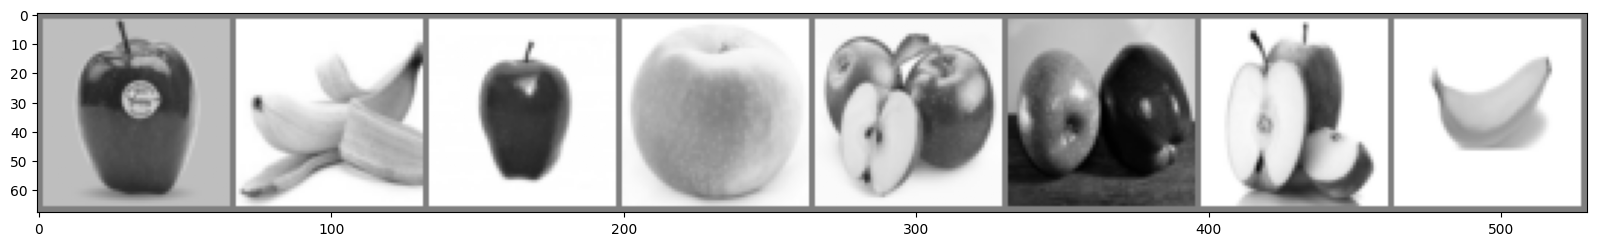

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1087741..2.6535122].


latent space


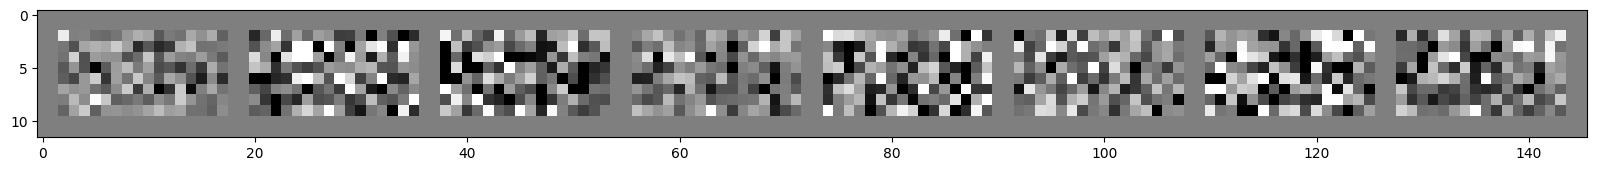

reconstructed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.1651297].


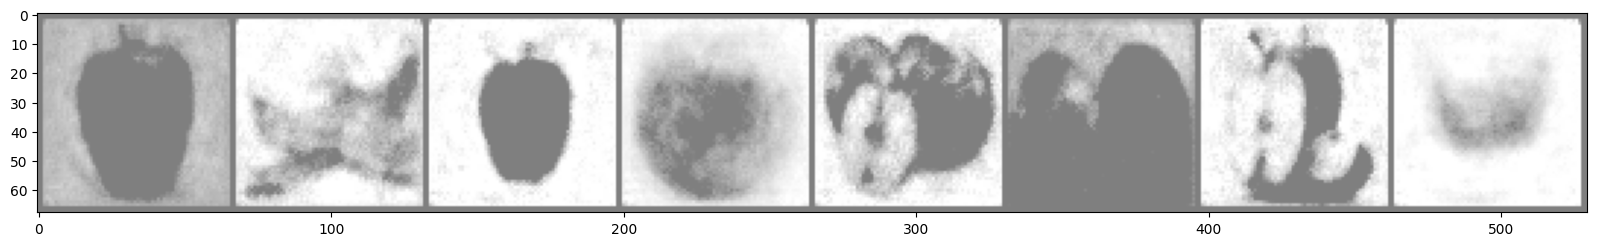

96.875

In [186]:
#%% packages
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils 

#%% Dataset and data loader
path_images = 'data/train'

transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

dataset = ImageFolder(root=path_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
# %% model class
LATENT_DIMS = 128
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 6, 3)  # out: 6, 62, 62
        self.conv2 = nn.Conv2d(6, 16, 3) # out: 16, 60, 60
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() # out: 16*60*60 = 57600
        self.fc = nn.Linear(16*60*60, LATENT_DIMS)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc = nn.Linear(LATENT_DIMS, 16*60*60)
        self.conv2 = nn.ConvTranspose2d(16, 6, 3)
        self.conv1 = nn.ConvTranspose2d(6, 1, 3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16, 60, 60)  # infer first dim from other dims
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test it
input = torch.rand((1, 1, 64, 64))
model = Autoencoder()
model(input).shape


#%% init model, loss function, optimizer
model = Autoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.view(-1, 1, 64, 64)
        output = model(data)

        loss = F.mse_loss(output, data)
        losses_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch} \tLoss: {np.mean(losses_epoch)}")  

# %% visualise original and reconstructed images
def show_image(img):
    img = 0.5 * (img + 1)  # denormalizeA
    # img = img.clamp(0, 1) 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(dataloader))
print('original')
plt.rcParams["figure.figsize"] = (20,3)
show_image(torchvision.utils.make_grid(images))

# %% latent space
print('latent space')
latent_img = model.encoder(images)
latent_img = latent_img.view(-1, 1, 8, 16)
show_image(torchvision.utils.make_grid(latent_img))
#%%
print('reconstructed')
show_image(torchvision.utils.make_grid(model(images)))


# %% Compression rate
image_size = images.shape[2] * images.shape[3] * 1
compression_rate = (1 - LATENT_DIMS / image_size) * 100
compression_rate


## Fake Celebrity Face Generator

Generative Adverserial Networks (GANs) were among the first proper generative models exposed to public. While diffusion models and other advanced architectures superceded GANs we got many research in GANs with one being its variant VAE-GAN which is using an Encoder-Decoder model for generator and a normal GAN descriminator. This model improves on the DCGAN by helping the model learn the latent Gaussian distribution of dataset. We will also use other techniques used to handle mode collapse like feature mapping, pixel regularization, and also allow option to use EMA based generator.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import lightning as L
from torchinfo import summary


torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")


/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [6]:
class CelebData(L.LightningDataModule):
    def __init__(self, data_dir = 'celeb_dataset/', img_size = 128, batch_size = 32):
        super().__init__()
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.CenterCrop(178),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
        ])

        self.train_ds = None

    def setup(self, stage = None):
        if stage in (None, 'fit'):
            self.train_ds = datasets.ImageFolder(root = self.data_dir, transform = self.transform)

    def train_dataloader(self):
        return DataLoader(
            dataset = self.train_ds,
            batch_size= self.batch_size,
            shuffle = True,
            pin_memory = True,
            num_workers = 15, 
            persistent_workers= True, 
            prefetch_factor= 4 
        )

In [7]:
from torchvision.utils import make_grid

dm = CelebData(batch_size= 256, img_size = 64)
dm.setup()
imgs, _ = next(iter(dm.train_dataloader()))

Batch: torch.Size([256, 3, 64, 64]) -1.0 1.0


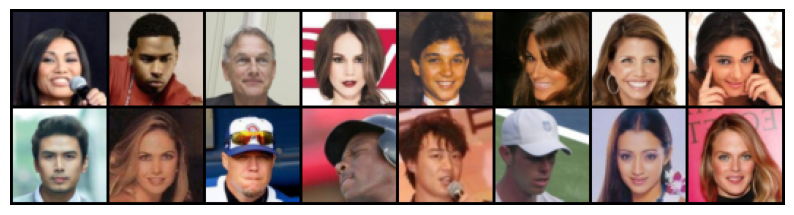

In [8]:
import matplotlib.pyplot as plt
def denorm(x):  # [-1,1] -> [0,1] for display
    return (x.clamp(-1, 1) + 1) * 0.5

print("Batch:", imgs.shape, imgs.min().item(), imgs.max().item())
grid = make_grid(denorm(imgs[:16]), nrow=8)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

For the project we will use 64, 64 shaped images as 128, 128 shape while being more useful were being difficult to train on our local machine. We were getting very slow training due to VRAM bottleneck due to 8 GB VRAM and even got OOM errors initially. For production use we can upscale the generated images to improve the image or train the model on a better hardware directly.

In [10]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dims=64):
        super().__init__()
        self.latent_dims = latent_dims

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),  # 128 -> 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),          # keep 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False), # 64 -> 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),           # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False), # 32 -> 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.head = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False), # 16 -> 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=False), # 8 -> 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(256, self.latent_dims)
        self.logvar = nn.Linear(256, self.latent_dims)

    def forward(self, inputs):
        x = self.block1(inputs)  # 64x64
        x = self.block2(x)       # 64x64
        x = self.block3(x)       # 32x32
        x = self.block4(x)       # 32x32
        x = self.block5(x)       # 16x16
        x = self.head(x)         # 8x8 -> MLP -> 256
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

summary(Encoder(), input_size= (64,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [64, 64]                  --
├─Sequential: 1-1                        [64, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 64, 64, 64]          1,728
│    └─BatchNorm2d: 2-2                  [64, 64, 64, 64]          128
│    └─LeakyReLU: 2-3                    [64, 64, 64, 64]          --
│    └─Conv2d: 2-4                       [64, 64, 32, 32]          36,864
│    └─BatchNorm2d: 2-5                  [64, 64, 32, 32]          128
│    └─LeakyReLU: 2-6                    [64, 64, 32, 32]          --
├─Sequential: 1-2                        [64, 128, 32, 32]         --
│    └─Conv2d: 2-7                       [64, 128, 32, 32]         73,728
│    └─BatchNorm2d: 2-8                  [64, 128, 32, 32]         256
│    └─LeakyReLU: 2-9                    [64, 128, 32, 32]         --
│    └─Conv2d: 2-10                      [64, 128, 32, 32]         147,

In [11]:
class Decoder(nn.Module):
    def _block(self, in_channels = 512, out_channels = 256):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode = 'nearest'),
            nn.Conv2d(in_channels= in_channels, out_channels= out_channels, padding= 1, kernel_size=3, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace= True),
            nn.Conv2d(in_channels= out_channels, out_channels= out_channels, padding= 1, kernel_size=3, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace= True)
        )
    
    
    def __init__(self, latent_dims = 64):
        super().__init__()
        self.fc = nn.Linear(latent_dims, (512*8*8))
        self.latent_dims = latent_dims
        self.block1 = self._block(in_channels= 512, out_channels= 256)
        self.block2 = self._block(in_channels= 256, out_channels= 128)
        self.block3 = self._block(in_channels= 128, out_channels= 64)

        self.head = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels = 3, kernel_size= 3, padding = 1), 
            nn.Tanh()
        )

    def forward(self, inputs):
        batch_size = inputs.size(0)
        x = self.fc(inputs).view(batch_size, 512, 8, 8)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) 
        x = self.head(x) 
        return x

summary(Decoder(), input_size= (64,64))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 3, 64, 64]           --
├─Linear: 1-1                            [64, 32768]               2,129,920
├─Sequential: 1-2                        [64, 256, 16, 16]         --
│    └─Upsample: 2-1                     [64, 512, 16, 16]         --
│    └─Conv2d: 2-2                       [64, 256, 16, 16]         1,179,648
│    └─BatchNorm2d: 2-3                  [64, 256, 16, 16]         512
│    └─ReLU: 2-4                         [64, 256, 16, 16]         --
│    └─Conv2d: 2-5                       [64, 256, 16, 16]         589,824
│    └─BatchNorm2d: 2-6                  [64, 256, 16, 16]         512
│    └─ReLU: 2-7                         [64, 256, 16, 16]         --
├─Sequential: 1-3                        [64, 128, 32, 32]         --
│    └─Upsample: 2-8                     [64, 256, 32, 32]         --
│    └─Conv2d: 2-9                       [64, 128, 32, 32]      

In [21]:
from torch.nn.utils import spectral_norm

class DBlock(nn.Module):
    """
    One downsampling stage:
    - Two 3x3 stride-1 convs to refine at current resolution
    - One 4x4 stride-2 conv to downsample
    """
    def __init__(self, in_ch, out_ch, use_spectralnorm=True):
        super().__init__()
        sn = (lambda m: spectral_norm(m)) if use_spectralnorm else (lambda m: m)
        self.block = nn.Sequential(
            sn(nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=not use_spectralnorm)),
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=not use_spectralnorm)),
            nn.LeakyReLU(0.2, inplace=True),

            sn(nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=not use_spectralnorm)),  # downsample
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, base_ch=64, use_spectralnorm=True, return_features=True):
        super().__init__()
        sn = (lambda m: spectral_norm(m)) if use_spectralnorm else (lambda m: m)
        c = base_ch

        # Stem: first stride-2 to 64x64
        self.stem = nn.Sequential(
            sn(nn.Conv2d(img_channels, c, kernel_size=4, stride=2, padding=1, bias=not use_spectralnorm)),  # 128->64
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.d1 = DBlock(c,      c*2,   use_spectralnorm)  
        self.d2 = DBlock(c*2,    c*4,   use_spectralnorm)  
        self.d3 = DBlock(c*4,    c*8,   use_spectralnorm) 

        self.out = spectral_norm(nn.Conv2d(c*8, 1, kernel_size=4, stride=1, padding=0, bias=True))

        self.return_features = return_features

    def forward(self, x):
        h = self.stem(x)     
        h = self.d1(h)      
        feat = self.d2(h)    # 8x8
        h = self.d3(feat) 
        logits = self.out(h).view(x.size(0), 1)
        if self.return_features:
            return logits, feat
        return logits
summary(Discriminator(), input_size=(64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1]                   --
├─Sequential: 1-1                        [64, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          3,072
│    └─LeakyReLU: 2-2                    [64, 64, 32, 32]          --
├─DBlock: 1-2                            [64, 128, 16, 16]         --
│    └─Sequential: 2-3                   [64, 128, 16, 16]         --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          36,864
│    │    └─LeakyReLU: 3-2               [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-3                  [64, 64, 32, 32]          36,864
│    │    └─LeakyReLU: 3-4               [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-5                  [64, 128, 16, 16]         131,072
│    │    └─LeakyReLU: 3-6               [64, 128, 16, 16]         --
├─DBlock: 1-3                            [64, 256, 8, 8]           --

In [23]:
import torch.nn.functional as F
from torchvision.utils import make_grid

def d_hinge_loss(real_logits, fake_logits):
    loss_real = F.relu(1.0 - real_logits).mean()
    loss_fake = F.relu(1.0 + fake_logits).mean()
    return loss_real + loss_fake

def g_hinge_loss(fake_logits):
    return -fake_logits.mean()

def kl_divergence(mu, logvar):
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    return kl.sum(dim=1).mean()

@torch.no_grad()
def ema_update(target_net, source_net, decay=0.999):
    for p_t, p_s in zip(target_net.parameters(), source_net.parameters()):
        p_t.data.mul_(decay).add_(p_s.data, alpha=(1.0 - decay))

class VAE_GAN(L.LightningModule):
    def __init__(
        self,
        encoder, decoder, discriminator,
        latent_dims=64,
        lr_g=2e-4, lr_d=2e-4, betas=(0.0, 0.9),
        lambda_fm=1.0,      # feature matching weight
        lambda_pix=0.05,    # small pixel L1 weight
        beta_target=0.5,    # KL target weight
        warmup_epochs=50,
        use_ema=True, ema_decay=0.999,
        sample_n=16,
    ):
        super().__init__()
        self.E = encoder
        self.G = decoder      
        self.D = discriminator

        self.latent_dims = latent_dims
        self.lr_g, self.lr_d, self.betas = lr_g, lr_d, betas
        self.lambda_fm, self.lambda_pix = lambda_fm, lambda_pix
        self.beta_target, self.warmup_epochs = beta_target, warmup_epochs

        self.automatic_optimization = False

        # fixed noise for sampling
        self.register_buffer("z_fixed", torch.randn(sample_n, latent_dims))
        self.sample_n = sample_n

        # EMA for generator
        self.use_ema = use_ema
        if use_ema:
            import copy
            self.G_ema = copy.deepcopy(self.G).eval()
            for p in self.G_ema.parameters():
                p.requires_grad_(False)
            self.ema_decay = ema_decay
        else:
            self.G_ema = None

        self.save_hyperparameters(ignore=["E", "G", "D", "G_ema"])

    def _beta(self):
        progress = min(1.0, (self.current_epoch + 1) / float(self.warmup_epochs))
        return self.beta_target * progress

    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    @staticmethod
    def _denorm(x):
        return (x.clamp(-1, 1) + 1) * 0.5

    def configure_optimizers(self):
        opt_d  = torch.optim.Adam(self.D.parameters(), lr=self.lr_d, betas=self.betas)
        opt_ge = torch.optim.Adam(list(self.G.parameters()) + list(self.E.parameters()),
                                  lr=self.lr_g, betas=self.betas)
        return [opt_d, opt_ge]

    def on_train_start(self):
        self._sum_d = self._sum_g = self._sum_adv = self._sum_fm = self._sum_pix = self._sum_kl = 0.0
        self._n = 0

    def training_step(self, batch, batch_idx):
        real, _ = batch
        B = real.size(0)
        device = real.device

        opt_d, opt_ge = self.optimizers()

        # Discriminator training 
        opt_d.zero_grad(set_to_none=True)
        for p in self.D.parameters(): p.requires_grad_(True)
            
        with torch.no_grad():
            # recon fakes
            mu, logvar = self.E(real)
            z_post = self._reparameterize(mu, logvar)
            fake_recon = self.G(z_post)
            # prior fakes/pure fakes
            z_prior = torch.randn(B, self.latent_dims, device=device)
            fake_prior = self.G(z_prior)

        real_logits, _       = self.D(real)
        fake_recon_logits, _ = self.D(fake_recon)
        fake_prior_logits, _ = self.D(fake_prior)

        fake_logits = torch.cat([fake_recon_logits, fake_prior_logits], dim=0)
        d_loss = d_hinge_loss(real_logits, fake_logits)

        self.manual_backward(d_loss)
        opt_d.step()
        self.log("train/d_loss", d_loss, on_epoch=True, prog_bar=True, batch_size=B)

        # Generator Training
        opt_ge.zero_grad(set_to_none=True)
        for p in self.D.parameters(): p.requires_grad_(False)
        
        mu, logvar = self.E(real)
        z_post = self._reparameterize(mu, logvar)
        fake_recon = self.G(z_post)

        fake_logits_recon, feat_fake = self.D(fake_recon)
        g_adv = g_hinge_loss(fake_logits_recon)

        # feature matching 
        with torch.no_grad():
            _, feat_real = self.D(real)
        fm = (feat_real - feat_fake).abs().mean()

        #prior generator
        z_prior = torch.randn(B, self.latent_dims, device=device)
        fake_prior = self.G(z_prior)
        fake_logits_prior, feat_prior = self.D(fake_prior)
        g_adv_prior = g_hinge_loss(fake_logits_prior)
        fm_prior = (feat_real.mean(dim=(2,3)) - feat_prior.mean(dim=(2,3))).abs().mean()
        
        pix = F.l1_loss(fake_recon, real)
        kl  = kl_divergence(mu, logvar)
        beta = self._beta()
        
        g_loss = self.lambda_fm * fm + self.lambda_pix * pix + beta * kl + g_adv
        g_loss = g_loss + g_adv_prior + 0.5*fm_prior

        self.manual_backward(g_loss)
        opt_ge.step()
        
        if self.use_ema:
            ema_update(self.G_ema, self.G, decay=self.ema_decay)

        self.log_dict({
            "train/g_loss": g_loss,
            "train/g_adv": g_adv,
            "train/fm": fm,
            "train/pix": pix,
            "train/kl": kl,
            "train/beta": beta,
        }, on_epoch=True, prog_bar=True, batch_size=B)

        # epoch-only stats
        self._sum_d += float(d_loss.detach())
        self._sum_g += float(g_loss.detach())
        self._sum_adv += float((g_adv + g_adv_prior).detach())
        self._sum_fm  += float((fm + fm_prior).detach())
        self._sum_pix += float(pix.detach())
        self._sum_kl  += float(kl.detach())
        self._n += 1
    
    def on_train_epoch_end(self):
        if self._n:
            print(f"epoch {self.current_epoch}: "
                  f"d={self._sum_d/self._n:.3f} "
                  f"g={self._sum_g/self._n:.3f} "
                  f"adv={(self._sum_adv/self._n):.3f} "
                  f"fm={(self._sum_fm/self._n):.3f} "
                  f"pix={(self._sum_pix/self._n):.3f} "
                  f"kl={(self._sum_kl/self._n):.3f}")
        self._sum_d = self._sum_g = self._sum_adv = self._sum_fm = self._sum_pix = self._sum_kl = 0.0
        self._n = 0


In [35]:
E = Encoder(latent_dims=64)
G = Decoder(latent_dims=64)  
D = Discriminator(img_channels=3, base_ch=64, use_spectralnorm=True, return_features=True)

model = VAE_GAN(
    encoder=E, decoder=G, discriminator=D,
    latent_dims = 64,
    warmup_epochs = 10,
    beta_target = 0.7,
    use_ema = False
)

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.


In [36]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

ckpt_cb = ModelCheckpoint(
    dirpath="checkpoints/vae_gan",
    filename="best-{epoch:03d}-{train_g_loss:.3f}",
    save_top_k=1,            
    monitor="train/g_loss", 
    mode="min",    
    save_last=True,
    auto_insert_metric_name=False
)

trainer = L.Trainer(
    max_epochs= 35,
    accelerator= 'auto', 
    precision= '16-mixed', 
    log_every_n_steps=50,
    num_sanity_val_steps=0,
    callbacks= [ckpt_cb]
)

trainer.fit(model, dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /mnt/c/Users/anubh/pytorch coursera/220_GAN/checkpoints/vae_gan exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | E    | Encoder       | 7.4 M  | train
1 | G    | Decoder       | 4.5 M  | train
2 | D    | Discriminator | 4.3 M  | train
-----------------------------------------------
16.1 M    Trainable params
0         Non-traina

Training: |                                                                                       | 0/? [00:00…

epoch 0: d=2.002 g=0.028 adv=-0.009 fm=0.003 pix=0.572 kl=0.091
epoch 1: d=2.000 g=0.035 adv=0.001 fm=0.003 pix=0.591 kl=0.009
epoch 2: d=1.999 g=0.046 adv=0.007 fm=0.008 pix=0.599 kl=0.008
epoch 3: d=1.996 g=0.081 adv=0.037 fm=0.013 pix=0.602 kl=0.008
epoch 4: d=1.989 g=0.198 adv=0.147 fm=0.020 pix=0.604 kl=0.008
epoch 5: d=1.978 g=0.364 adv=0.306 fm=0.027 pix=0.604 kl=0.010
epoch 6: d=1.961 g=0.543 adv=0.478 fm=0.033 pix=0.602 kl=0.010
epoch 7: d=1.945 g=0.693 adv=0.624 fm=0.038 pix=0.602 kl=0.010
epoch 8: d=1.931 g=0.793 adv=0.719 fm=0.041 pix=0.602 kl=0.010
epoch 9: d=1.924 g=0.853 adv=0.776 fm=0.044 pix=0.604 kl=0.010
epoch 10: d=1.914 g=0.892 adv=0.814 fm=0.046 pix=0.604 kl=0.009
epoch 11: d=1.909 g=0.919 adv=0.839 fm=0.048 pix=0.604 kl=0.010
epoch 12: d=1.903 g=0.933 adv=0.851 fm=0.050 pix=0.605 kl=0.010
epoch 13: d=1.898 g=0.937 adv=0.854 fm=0.052 pix=0.604 kl=0.011
epoch 14: d=1.893 g=0.939 adv=0.853 fm=0.054 pix=0.604 kl=0.010
epoch 15: d=1.888 g=0.949 adv=0.862 fm=0.055 pix=

`Trainer.fit` stopped: `max_epochs=35` reached.


In [42]:
ckpt_path = 'checkpoints/vae_gan/last-v2.ckpt'

E = Encoder(latent_dims=64)
G = Decoder(latent_dims=64)
D = Discriminator(img_channels=3, base_ch=64, use_spectralnorm=True, return_features=True)

model = VAE_GAN.load_from_checkpoint(
    ckpt_path,
    encoder=E, decoder=G, discriminator=D,
    map_location="cuda" 
)

model.beta_target = 0.3     
model.warmup_epochs = 1       
model.lr_d = 1.5e-4
model.lr_g = 0.0005

/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.


In [43]:
trainer = L.Trainer(
    max_epochs= 16,
    accelerator= 'auto', 
    precision= '16-mixed',
    callbacks = [ckpt_cb]
)

trainer.fit(model, dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /mnt/c/Users/anubh/pytorch coursera/220_GAN/checkpoints/vae_gan exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/anubh/miniconda3/envs/dl-env/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | E    | Encoder       | 7.4 M  | train
1 | G    | Decoder       | 4.5 M  | train
2 | D    | Discriminator | 4.3 M  | train
-----------------------------------------------
16.1 M    Trainable params
0         Non-traina

Training: |                                                                                       | 0/? [00:00…

epoch 0: d=1.686 g=1.231 adv=1.104 fm=0.086 pix=0.593 kl=0.069
epoch 1: d=1.711 g=1.212 adv=1.080 fm=0.092 pix=0.596 kl=0.068
epoch 2: d=1.743 g=1.201 adv=1.066 fm=0.094 pix=0.599 kl=0.072
epoch 3: d=1.773 g=1.209 adv=1.078 fm=0.092 pix=0.604 kl=0.066
epoch 4: d=1.789 g=1.213 adv=1.082 fm=0.090 pix=0.604 kl=0.069
epoch 5: d=1.808 g=1.196 adv=1.069 fm=0.089 pix=0.603 kl=0.060
epoch 6: d=1.820 g=1.183 adv=1.056 fm=0.089 pix=0.603 kl=0.059
epoch 7: d=1.832 g=1.158 adv=1.034 fm=0.087 pix=0.601 kl=0.055
epoch 8: d=1.837 g=1.131 adv=1.009 fm=0.086 pix=0.601 kl=0.051
epoch 9: d=1.845 g=1.126 adv=1.004 fm=0.086 pix=0.602 kl=0.049
epoch 10: d=1.853 g=1.136 adv=1.017 fm=0.087 pix=0.601 kl=0.038
epoch 11: d=1.855 g=1.095 adv=0.981 fm=0.086 pix=0.601 kl=0.023
epoch 12: d=1.861 g=1.088 adv=0.975 fm=0.087 pix=0.603 kl=0.019
epoch 13: d=1.862 g=1.088 adv=0.975 fm=0.087 pix=0.602 kl=0.019
epoch 14: d=1.864 g=1.088 adv=0.975 fm=0.087 pix=0.603 kl=0.017
epoch 15: d=1.866 g=1.081 adv=0.968 fm=0.088 pix=0

`Trainer.fit` stopped: `max_epochs=16` reached.


In [44]:
import torchvision.utils as vutils

@torch.no_grad()
def denorm(x):
    # assumes outputs are in [-1, 1] (Tanh); return [0, 1]
    return (x.clamp(-1, 1) + 1) * 0.5

@torch.no_grad()
def get_G_for_sampling(model):
    # Prefer EMA if present
    if hasattr(model, "G_ema") and model.G_ema is not None:
        return model.G_ema.eval()
    return model.G.eval()

@torch.no_grad()
def sample_prior(model, n=16, out_path="samples_prior.png", device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    G = get_G_for_sampling(model)
    z = torch.randn(n, model.latent_dims, device=device)
    imgs = denorm(G(z))
    vutils.save_image(imgs, out_path, nrow=int(n**0.5), padding=2)
    print(f"Saved prior samples to {out_path}")

@torch.no_grad()
def sample_reconstructions(model, dataloader, n=16, out_path="samples_recon.png", device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.E.eval(); model.D.eval()
    G = get_G_for_sampling(model)

    real, _ = next(iter(dataloader))
    real = real[:n].to(device)
    mu, logvar = model.E(real)
    z = model._reparameterize(mu, logvar)
    recon = denorm(G(z))
    real_vis = denorm(real)
    # stack real and recon vertically (two rows)
    grid = torch.cat([real_vis, recon], dim=0)
    vutils.save_image(grid, out_path, nrow=n, padding=2)
    print(f"Saved recon pairs (top: real, bottom: recon) to {out_path}")

@torch.no_grad()
def sample_interpolation(model, steps=8, out_path="samples_interp.png", device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    G = get_G_for_sampling(model)
    z0 = torch.randn(1, model.latent_dims, device=device)
    z1 = torch.randn(1, model.latent_dims, device=device)
    alphas = torch.linspace(0, 1, steps, device=device).view(steps, 1)
    z = (1 - alphas) * z0 + alphas * z1  # [steps, z_dim]
    imgs = denorm(G(z))
    vutils.save_image(imgs, out_path, nrow=steps, padding=2)
    print(f"Saved interpolation row to {out_path}")


In [45]:
# If you already have `model` in memory:
sample_prior(model, n=16, out_path="prior.png")
sample_reconstructions(model, dm.train_dataloader(), n=16, out_path="recon.png")
sample_interpolation(model, steps=10, out_path="interp.png")


Saved prior samples to prior.png
Saved recon pairs (top: real, bottom: recon) to recon.png
Saved interpolation row to interp.png


(np.float64(-0.5), np.float64(265.5), np.float64(265.5), np.float64(-0.5))

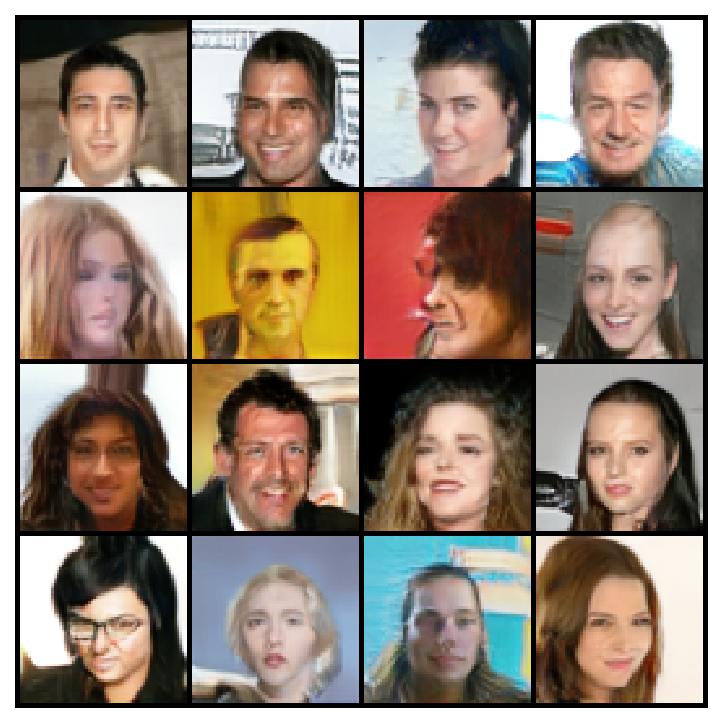

In [55]:
img = plt.imread("prior.png")

plt.figure(figsize=(24, 6), dpi=150)  # wider and taller; tweak numbers
plt.imshow(img, interpolation="nearest")  # 'nearest' keeps grid edges crisp
plt.axis("off")


Our hyperparameter finetuning helped generator to create better fake images, while some of the above randomly generated images do appear strange, most of them are very competent fake images which are very similar to our dataset.

(np.float64(-0.5), np.float64(1057.5), np.float64(133.5), np.float64(-0.5))

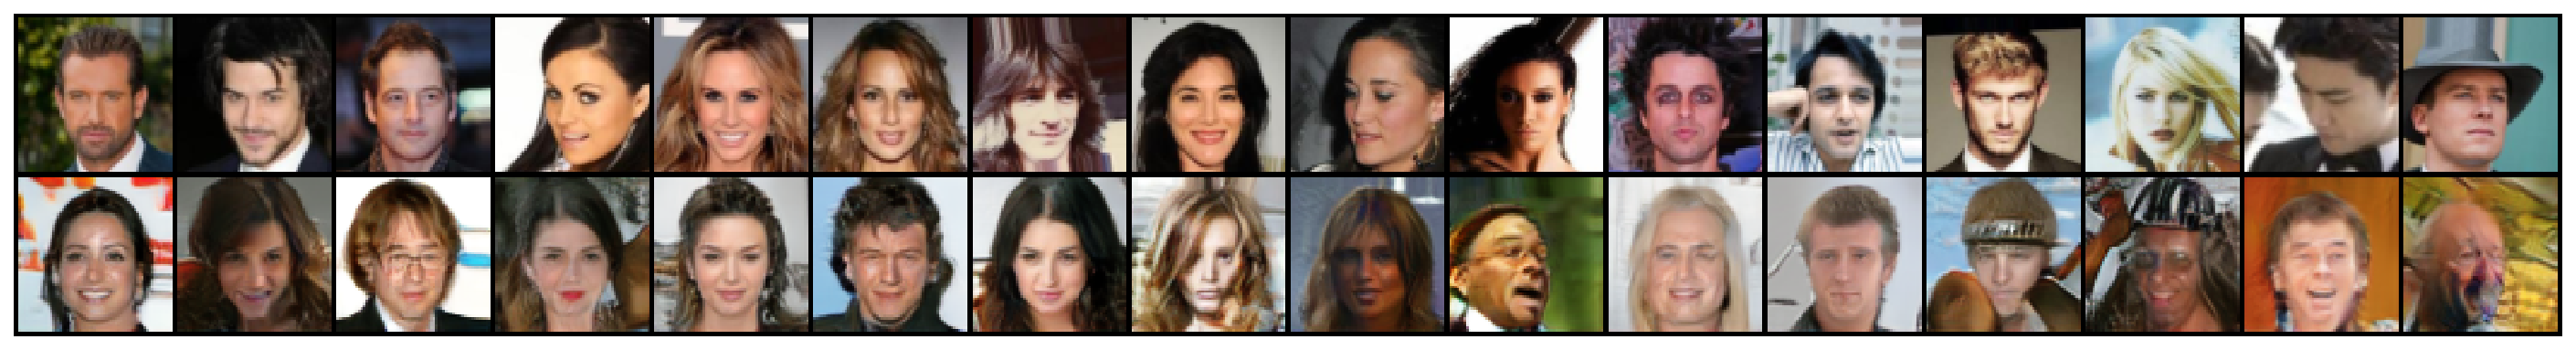

In [52]:
img = plt.imread("recon.png")

plt.figure(figsize=(24, 6), dpi=150)  # wider and taller; tweak numbers
plt.imshow(img, interpolation="nearest")  # 'nearest' keeps grid edges crisp
plt.axis("off")

#top: real, bottom: fake

We encoded real images and use mu, logvar of them as input of generator. And as we see above, we obtained very good results overall as most of the fake images are quite credible. And VAE-GAN is also learning the latent distribution properly as it was able to make new images properly by even changing genders and race in some cases.

(np.float64(-0.5), np.float64(661.5), np.float64(67.5), np.float64(-0.5))

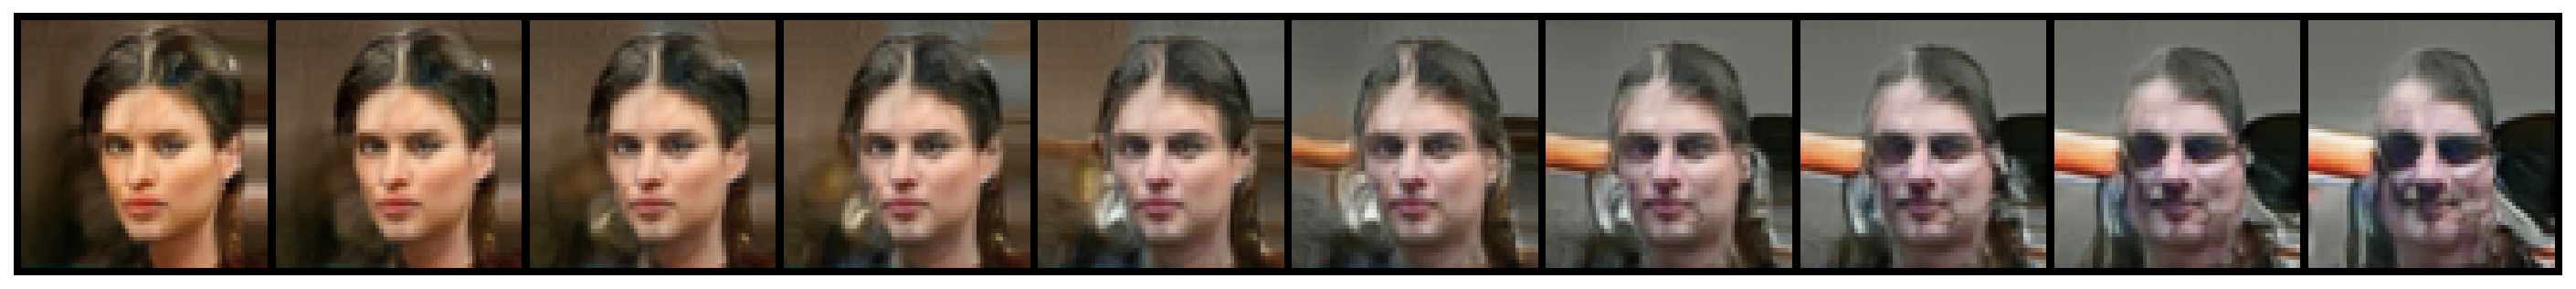

In [54]:
img = plt.imread("interp.png")

plt.figure(figsize=(24, 6), dpi=150)  # wider and taller; tweak numbers
plt.imshow(img, interpolation="nearest")  # 'nearest' keeps grid edges crisp
plt.axis("off")

And above we can see the latent dimensions learning proeprly, model was able to go from a fake female celebrity face to bald masculine face, if we went further we would have indeed gotten a bald representation and we can visually observe addition of masculine features as image morphs.

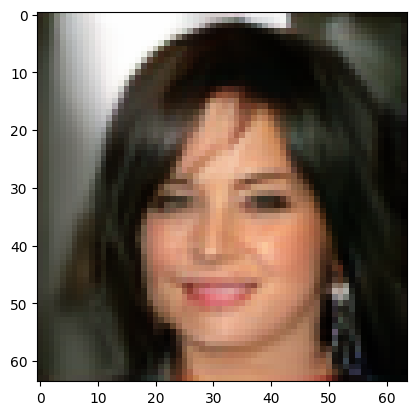

In [111]:
#random images
test_img = denorm(model.G.eval()(torch.randn(1,64, device = 'cuda'))).detach().cpu()
plt.imshow(test_img.permute(0,2,3,1).view((64,64,3)))
plt.show()

And finally, above celebrity face image while being blurry due to its limits 64,64 shape is clearly a well made fake celebrity image. In general extra training by putting the competition in favor of generator helped a lot, and 2-3 rounds of it would lead to huge model improvements too but it is outside the scope of this project. Generator itself is very capable in making realistic female faces, this may signify some bias for female celebrities in original dataset as its likely that we have more samples of them.

In conclusion, by using pytorch we were able to use custom VAE-GAN architecture on 200k+ celebrity images to create a Generative AI model which is able to make very credible and realistic looking Fake Celebrity Images. We can improve the model by training it for few more rounds by balancing the adverserial elements in favor of Generator. We can also improve the quality of the model by making a 128,128 shaped model or using bilinear interpolation or other advanced upscaling. Besides that, we can also use Diffusion model instead directly and get better images or use LoRA Finetuning on an existing SDLX model.